# Damage function formulation within a thermodynamic material model

The notebook shows how to construct a damage function as an evolution law within a time-stepping inelastic algorithm which
 - implicitly approaches the value 1 in a limit
 - has a desirebed algebraic shape with specified material parameters
 - can support self-regularization in terms of a fracture energy parameter
   which controls the integral of the stress-strain response. 

In [141]:
%matplotlib widget
import sympy as sp
import numpy as np
import matplotlib.pylab as plt
sp.init_printing()

# Self-regularized softening function

Let us consider a softening function of the form
\begin{align}
f(w) = c_1 exp( - c_2 w )
\end{align}
This is function should describe the decay of stress starting from the material tensile strength and continuously deminishing to zero.
The variable $w$ represents the crack opening and the parameters $c_1$ and $c_2$ are the material parameters.

In [195]:
w = sp.symbols('w')
c_1 = sp.symbols('c_1')
c_2 = sp.symbols('c_2')

In [196]:
f_w = c_1 * sp.exp(-c_2*w)
f_w

Let us plot the function to verify its shape for the material parameters set to the value 1

In [197]:
w_arr = np.linspace(0.01,10,100)
fig, ax = plt.subplots(1,1,figsize=(5,3), tight_layout=True)
ax.plot(w_arr, sp.lambdify((w, c_1, c_2), f_w)(w_arr,1,1));

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

The function can be already used in this form. The question is however, how to set the material parameters $c_1$ and $c_2$. They can be directly associated to a particular type of material parameters - namely, to the tensile strength $f_\mathrm{t}$ and fracture energy $G_\mathrm{f}$ 

In [145]:
f_t, G_f = sp.symbols('f_t, G_f', positive=True)

Softening starts at the level of the material strength so that we can set $f(w = 0) = f_\mathrm{t}$  to obtain the equation

In [146]:
Eq1 = f.subs({'w':0}) - f_t
Eq1

By solving for the $c_1$ we obtain the first substitution for our softening function.

In [147]:
c_1_subs = sp.solve({Eq1}, c_1)
c_1_subs

Thus, if $w_0 = 0$, $c_1$ is equivalent to the tensile strength $f_\mathrm{t}$

The second possible mechanical interpretation is provided by the statement that softening directly represents the energy dissipation of a unit crack area. Thus, for large $w \rightarrow \infty$ it is equivalent to the energy producing a stress-free crack. This is the meaning of fracture energy.

We can thus obtain the fracture energy represented by the softening function by evaluating its integral in the range $w \in (0, \infty)$. 

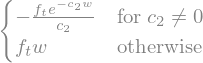

In [148]:
int_f_w = sp.integrate(f.subs(c_1_subs), w)
int_f_w

As $c_2 > 0$, only the second term matters.
The determinate integral
\begin{align}
\left[ - \frac{f_\mathrm{t}}{c_2} 
\exp(-c_2 w) \right]_0^{\infty}
\end{align}
is zero for $w = \infty$, so that the value in $w = 0$ delivers the result of the integral
\begin{align}
\frac{f_\mathrm{t}}{c_2} 
\end{align}

This integral is equal to the fracture energy $G_\mathrm{f}$.

In [149]:
E_0 = sp.symbols('E_0', positive=True ) 

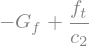

In [150]:
Eq2 = -int_f_w.args[0][0].subs({'w':0}) - G_f
Eq2

and the value of $c_2$ delivers the second substitution for the softening function

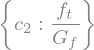

In [151]:
c_2_subs = sp.solve({Eq2}, c_2)
c_2_subs

The softening function with strength and fracture energy as a parameter now obtains the form

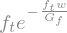

In [152]:
f_w = f.subs(c_1_subs).subs(c_2_subs)
sp.simplify(f_w)

Verify that the fracture energy is recovered at $w$ in infinity

In [153]:
sp.integrate(f_w, (w,0,sp.oo))

## Autoregularized damage function

In [176]:
from sympy import Function, dsolve, Eq, Derivative, sin, cos, symbols
from sympy.abc import x
u = sp.symbols(r'u') 
omega = Function('omega')
E_ = sp.symbols(r'E', positive=True)
S_ = sp.symbols(r'S', positive=True)
c_ = sp.symbols(r'c', positive=True)
G_ = sp.symbols(r'G_f', positive=True)
C_2 = sp.symbols(r'C_2', positive=True)

In [177]:
Y = sp.Rational(1,2) * E_ * u * u
#Y = 1

In [181]:
dot_omega_u = (1 - omega(u)) * C_2 * Y

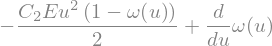

In [182]:
omega_evol_law = Derivative(omega(u), u) - dot_omega_u
omega_evol_law

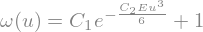

In [183]:
omega_u_eq = dsolve(omega_evol_law, omega(u))
omega_u_eq

In [184]:
omega_u = omega_u_eq.args[1]
omega_u

In [185]:
C1_solved = sp.solve(omega_u.subs(u,0), 'C1')[0]
C1_solved

In [186]:
omega_u_C2 = omega_u.subs('C1', C1_solved)
omega_u_C2

In [187]:
f_u_C2 = (1-omega_u_C2) * E_ * u

In [188]:
f_u_C2

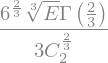

In [189]:
int_f_u_C2 = sp.integrate(f_u_C2, (u,0,sp.oo))
int_f_u_C2

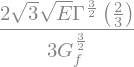

In [190]:
C2_solved = sp.solve(sp.Eq( G_, int_f_u_C2 ),  C_2)[0]
sp.simplify(C2_solved)

In [191]:
omega_u_solved = omega_u_C2.subs(C_2, C_2_solved)
f_u_solved = f_u_C2.subs(C_2, C_2_solved)

In [192]:
get_omega_u = sp.lambdify((u, E_, G_), omega_u_solved)
get_f_u = sp.lambdify((u, E_, G_), f_u_solved)

In [193]:
_, ax = plt.subplots(1,1)
ax2 = ax.twinx()
u_range = np.linspace(0,10,100)
ax.plot(u_range, get_f_u(u_range,1,0.1), label='f(u)')
ax2.plot(u_range, get_omega_u(u_range,1,0.1), color='red');
ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

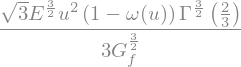

In [194]:
dot_omega_u.subs(C_2, C_2_solved)